### 基础认识：图像分类，手写数字识别。一般机器学习框架都使用MNIST手写体数字库作为入门。
### 就像"Hello World"对于任何一门编程语言一样，要想入门机器学习，
### 就先要掌握如何训练一个模型识别MNIST库中的手写数字。 
https://okai.brown.edu/zh/chapter0.html

每一个notebook都由下面三行开始；它们确保你对库代码进行任何编辑，这些代码都将自动重新加载，并且任何图表或图片能在notebook中展示。

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

我们首先导入所有需要的包，然后就可以使用构建于 [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163)之上的 [fastai V1库](http://www.fast.ai/2018/10/02/fastai-ai/)。fastai库提供了大量有用的函数，可以帮助我们简单快捷地构建神经网络，并且训练出我们的模型。

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
path = untar_data(URLs.MNIST); path

PosixPath('/home/bj109maker/.fastai/data/mnist_png')

下面在这短短的两行代码里面其实发生了很多事情。
首先，通过vision模块封装的get_transforms方法获得了一个tuple，这个tuple存放很多的Transform对象。（可以print查看，主要是对数据集随机试验crop，flip等增广数据集能力）
但是在get_transfroms的时候，加入参数do_flip=False，这是因为对手写数据集，不希望有随机的翻转，因为3转过来就不是3了。
然后，按照imagenet的风格从数据存放路径载入数据集，第一个参数为数据集路径，第二个参数为转化器，第三个参数为目标图片的大小。


In [ ]:
tfms = get_transforms(do_flip=False)
# data = (ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26))
data = (ImageDataBunch.from_folder(path)
        .random_split_by_pct()
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch())

In [22]:
path = untar_data(URLs.MNIST)
tfms = get_transforms(do_flip=False)

data = (ImageList.from_folder(path) 
        .split_by_rand_pct() 
        .label_from_folder()
        .transform(tfms, size=16)
        .databunch())

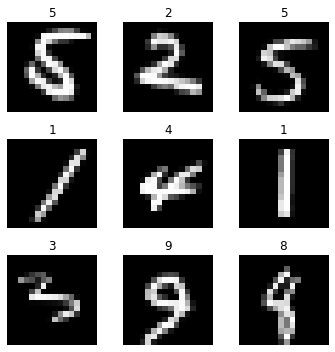

In [6]:
data.show_batch(rows=3, figsize=(5,5))

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 10, 56000, 14000)

In [8]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/bj109maker/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [9]:
learn.fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.793899,0.509600,0.838500,00:15
1,0.499451,0.287348,0.910429,00:14


### 学习率退火算法
#### fit_one_cycle在训练中，先使用较大的学习率，在逐步减小学习率。
#### 首先，在学习的过程中逐步增大学习率目的是为了不至于陷入局部最小值，边学习边计算loss。
#### 其次，当loss曲线向上扬即变大的时候，开始减小学习率，慢慢的趋近梯度最小值，loss也会慢慢减小。

In [10]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.403918,0.232088,0.925857,00:14
1,0.322130,0.195746,0.940429,00:14


In [11]:
learn.save('stage-1')

### 参数调优可视化查找最佳学习率区间

In [ ]:
learn.load('stage-1')

In [12]:
learn.unfreeze()

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


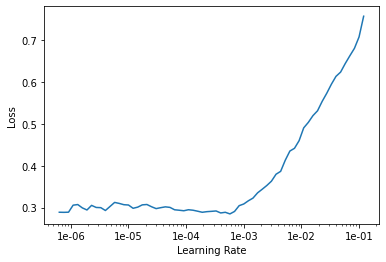

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.295163,0.183862,0.942357,00:16
1,0.298863,0.174567,0.946929,00:17


In [16]:
learn.save('stage-2')

### Interpretation 结果解读 模型准确率可视化评估

In [11]:
learn.load('stage-2');

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

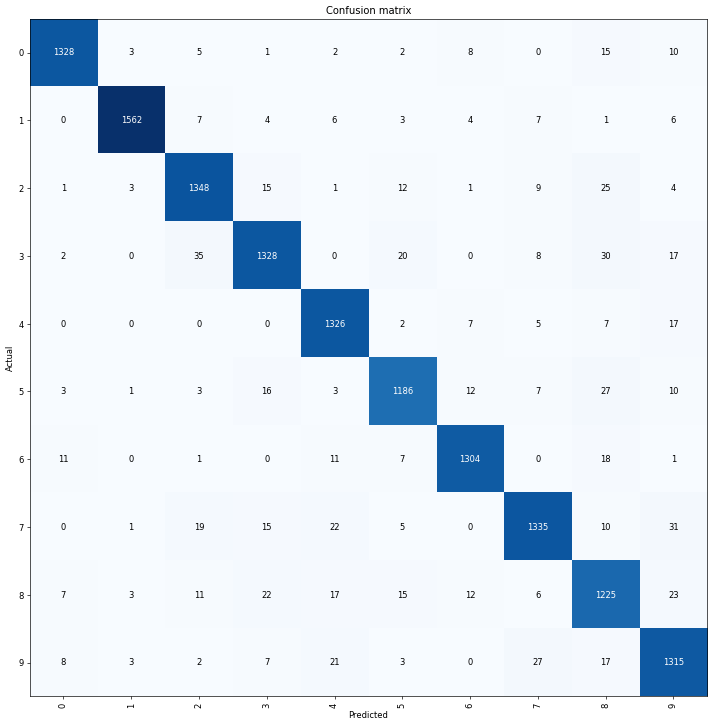

In [18]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

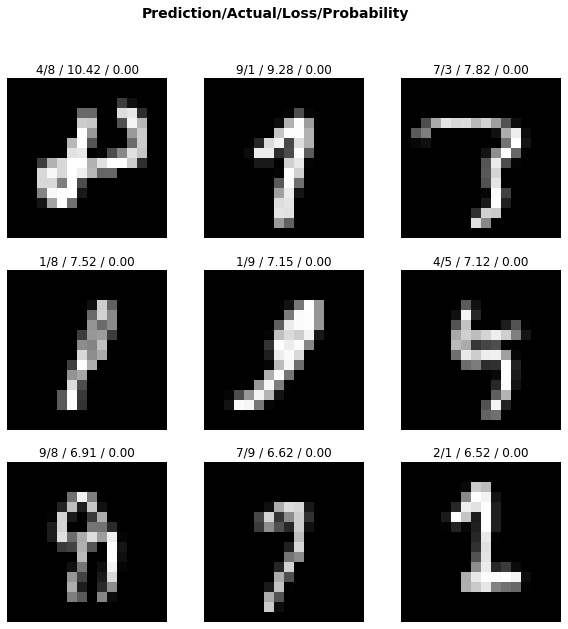

In [19]:
interp.plot_top_losses(9, figsize=(10,10))

#### 推理测试
你可能想用CPU来进行推断，除了大规模的（几乎可以肯定你不需要实时训练模型)，（所以）如果你没有GPU资源，你也可以使用CPU来对模型做简单的测试：

In [20]:
defaults.device = torch.device('cpu')

In [25]:
img = open_image(path/'testing'/'9'/'9945.png')
img

In [26]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class)
outputs


9


tensor([2.8764e-04, 2.5922e-04, 7.5568e-05, 1.3675e-04, 6.9267e-03, 2.6033e-05,
        2.7694e-05, 4.2203e-02, 1.3749e-03, 9.4868e-01])